<a href="https://colab.research.google.com/github/ndq3004/machine_learning/blob/master/MachineLearningCoBan/SVM/Soft_margin_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tạo lớp dữ liệu cho không gian 2 chiều

In [0]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(22)

means = [[2, 2],[4, 2]]
cov = [[.7, 0], [0, .7]]
N = 20 
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X = np.concatenate((X0, X1))
y = np.concatenate((np.ones(N), -np.ones(N)))

Mô phỏng dữ liệu 

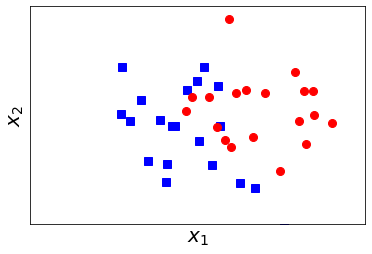

In [22]:
plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1)
plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1)
plt.axis('equal')
plt.ylim(0, 4)
plt.xlim(0, 5)

cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticks([])
cur_axes.axes.get_yaxis().set_ticks([])

plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.show()

Solve by Sklearn

In [25]:
from sklearn.svm import SVC
C = 100
clf = SVC(kernel='linear', C = C)
clf.fit(X, y)
w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]
print('w_sklearn = ', w_sklearn.T, ', b_sklearn = ', b_sklearn)
print('\nclf.coef_ =', clf.coef_)
print('\nclf.coef_.reshape(-1, 1) =', clf.coef_.reshape(-1, 1))

w_sklearn =  [[-1.87461946 -1.80697358]] , b_sklearn =  8.496911901960104

clf.coef_ = [[-1.87461946 -1.80697358]]

clf.coef_.reshape(-1, 1) = [[-1.87461946]
 [-1.80697358]]


Solve by Dual problem

In [26]:
from cvxopt import matrix, solvers

V = np.concatenate((X0, -X1), axis = 0)
K = matrix(V.dot(V.T))
p = matrix(-np.ones((2*N, 1)))

G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C * np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N)))
b = matrix(np.zeros((1, 1)))

solvers.options['show_progress'] = False
sol = solvers.qp(K, p, G, h, A, b)

l = np.array(sol['x']).reshape(2*N)

#support set
S = np.where(l > 1e-5)[0]
S2 = np.where(l < .999*C)[0]

#margin set
M = [val for val in S if val in S2]

VS = V[S]
lS = l[S]
w_dual = lS.dot(VS)
yM = y[M]
XM = X[M]
b_dual = np.mean(yM - XM.dot(w_dual))
print('w_dual = ', w_dual)
print('b_dual = ', b_dual)

w_dual =  [-1.87457279 -1.80695039]
b_dual =  8.496721098152724


Solve by Hinge loss(gradient decent)


In [62]:
lam = 1./C
def loss(X, y, w, b):
  """
  """
  z = X.dot(w) + b
  yz = y*z
  return (np.sum(np.maximum(0, 1 - yz)) + .5*lam*w.dot(w))/X.shape[0]

def grad(X, y, w, b):
  z = X.dot(w) + b
  yz = y*z 
  active_set = np.where(yz <= 1)[0]
  _yX = - X*y[:, np.newaxis]
  grad_w = (np.sum(_yX[active_set], axis=0) + lam*w)/X.shape[0]
  grad_b = (-np.sum(y[active_set]))/X.shape[0]
  return (grad_w, grad_b)

def num_grad(X, y, w, b):
  eps = 1e-10
  gw = np.zeros_like(w)
  gb = 0
  for i in range(len(w)):
    wp = w.copy()
    wm = w.copy()
    wp[i] += eps
    wm[i] -= eps
    gw[i] = (loss(X, y, wp, b) - loss(X, y, wm, b))/(2*eps)
  gb = (loss(X, y, w, b + eps) - loss(X, y, w, b - eps))/(2*eps)
  return (gw, gb)

w = .1*np.random.randn(X.shape[1])
b = np.random.randn()
(gw0, gb0) = grad(X, y, w, b)
(gw1, gb1) = num_grad(X, y, w, b)
print('grad_w difference = ', np.linalg.norm(gw0 - gw1))
print('grad_b difference = ', np.linalg.norm(gb0 - gb1))


grad_w difference =  4.3037810595376754e-07
grad_b difference =  0.0


In [64]:

def softmarginSVM_gd(X, y, w0, b0, eta):
    w = w0
    b = b0
    it = 0 
    while it < 10000:
        it = it + 1
        (gw, gb) = grad(X, y, w, b)
        w -= eta*gw
        b -= eta*gb
        if (it % 1000) == 0:
            print('iter %d' %it + ' loss: %f' %loss(X, y, w, b))
    return (w, b)

w0 = .1*np.random.randn(X.shape[1]) 
b0 = .1*np.random.randn()
lr = 0.05
(w_hinge, b_hinge) = softmarginSVM_gd(X, y, w0, b0, lr)
print('w_hinge = ', w_hinge)
print('b_hinge = ', b_hinge)

iter 1000 loss: 0.436559
iter 2000 loss: 0.405296
iter 3000 loss: 0.399817
iter 4000 loss: 0.395335
iter 5000 loss: 0.394134
iter 6000 loss: 0.394022
iter 7000 loss: 0.393821
iter 8000 loss: 0.394011
iter 9000 loss: 0.393970
iter 10000 loss: 0.393901
w_hinge =  [-1.37425569 -1.32100055]
b_hinge =  6.48066481979984


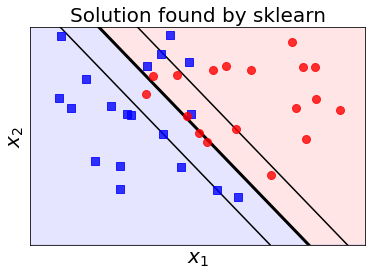

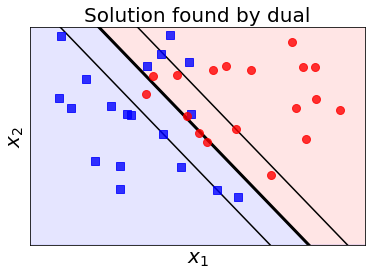

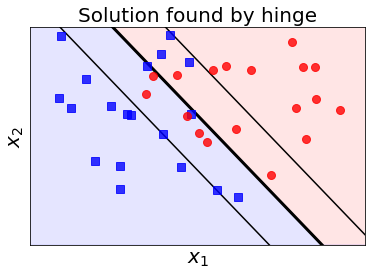

In [67]:
from matplotlib.backends.backend_pdf import PdfPages
def myplot(X0, X1, w, b, filename, tit):
  with PdfPages(filename) as pdf:
    fig, ax = plt.subplots()
    w0 = w[0]
    w1 = w[1]
    x1 = np.arange(-10, 10, 0.1)
    y1 = -w0/w1*x1 - b/w1
    y2 = -w0/w1*x1 - (b-1)/w1
    y3 = -w0/w1*x1 - (b+1)/w1
    plt.plot(x1, y1, 'k', linewidth = 3)
    plt.plot(x1, y2, 'k')
    plt.plot(x1, y3, 'k')

    #equal axis and lim
    plt.axis('equal')
    plt.ylim(0, 3)
    plt.xlim(2, 4)

    #hide ticks
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_ticks([])
    cur_axes.axes.get_yaxis().set_ticks([])

    #fill two regions
    y4 = 10 * x1
    plt.plot(x1, y1, 'k')
    plt.fill_between(x1, y1, color='blue', alpha=0.1)
    plt.fill_between(x1, y1, y4, color='red', alpha=.1)
    
    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('$x_2$', fontsize = 20)
    plt.title('Solution found by ' + tit, fontsize=20)
    plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize=8, alpha = .8)
    plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize=8, alpha = .8)
    pdf.savefig()
    plt.show()

myplot(X0, X1, w_sklearn, b_sklearn, 'svm_sklearm.pdf', 'sklearn')
myplot(X0, X1, w_dual, b_dual, 'svm_dual.pdf', 'dual')
myplot(X0, X1, w_hinge, b_hinge, 'svm_hinge.pdf', 'hinge')